# Geometry Test
Code for testing various geometric factors

## Import and Setup

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2

# numpy+scipy
import numpy as np
import scipy.interpolate
import scipy.integrate
import scipy.signal
import scipy.optimize

# matplotlib+tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

# Data loading
from netCDF4 import Dataset

# c1lgkt codes
from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler
from c1lgkt.fields.utility import periodify
from c1lgkt.fields.bicubic_interpolators import BicubicInterpolator

In [2]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='midplane', **geom_files)

## Testing BicubicInterpolator

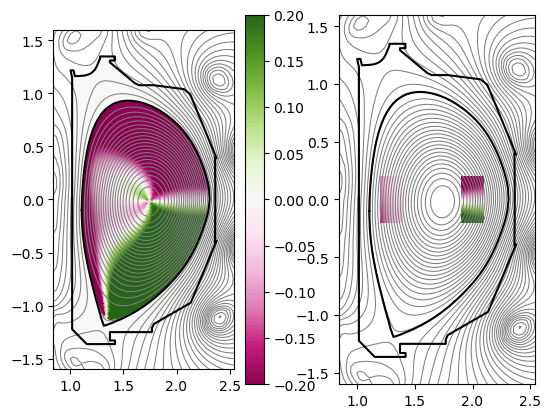

In [3]:
# %% Plot gdtheta and compare with nodal points

plt.figure()

ax = plt.subplot(121)
eq.plot_magnetic_geometry(ax)

cb = ax.tripcolor(geom.rz_tri, geom.gdtheta_node, cmap='PiYG', vmin=-0.2, vmax=0.2)
plt.colorbar(cb)

ax = plt.subplot(122, sharex=ax, sharey=ax)
eq.plot_magnetic_geometry(ax)

rplot, zplot = np.linspace(1.9, 2.1, 512), np.linspace(-0.2, 0.2, 1024)
psiplot = eq.interp_psi(rplot, zplot)
rgrid, zgrid = np.meshgrid(rplot, zplot)
gthetaplot = np.arctan2(zgrid - eq.zaxis, rgrid - eq.raxis).T

grad_gdtheta_plot = geom.interp_gdtheta_grid(psiplot, gthetaplot)

cb = plt.pcolormesh(rplot, zplot, grad_gdtheta_plot.T, cmap='PiYG', vmin=-0.2, vmax=0.2)


rplot, zplot = np.linspace(1.2, 1.4, 512), np.linspace(-0.2, 0.2, 1024)
psiplot = eq.interp_psi(rplot, zplot)
rgrid, zgrid = np.meshgrid(rplot, zplot)
gthetaplot = np.arctan2(zgrid - eq.zaxis, rgrid - eq.raxis).T

grad_gdtheta_plot = geom.interp_gdtheta_grid(psiplot, gthetaplot)

cb = plt.pcolormesh(rplot, zplot, grad_gdtheta_plot.T, cmap='PiYG', vmin=-0.2, vmax=0.2)

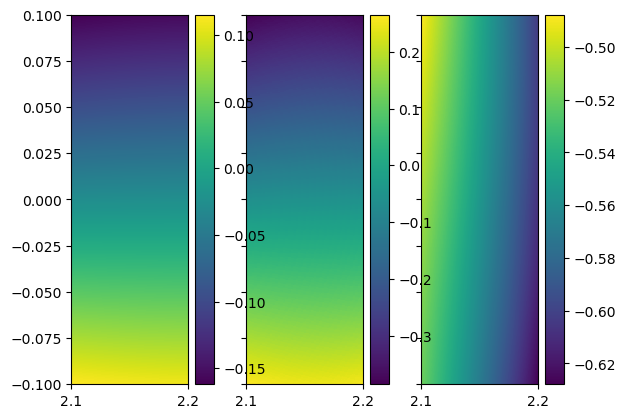

In [4]:
# %% Test smoothness of the derivative
rplot, zplot = np.linspace(2.1, 2.2, 512), np.linspace(-0.1, 0.1, 1024)
psiplot = eq.interp_psi(rplot, zplot)
rgrid, zgrid = np.meshgrid(rplot, zplot)
gthetaplot = np.arctan2(zgrid - eq.zaxis, rgrid - eq.raxis).T

gdtheta_plot, grad_gdtheta_plot = geom.interp_gdtheta_grid(psiplot, gthetaplot, nu=(0,1))

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

cb = axs[0].pcolormesh(rplot, zplot, gdtheta_plot.T)
plt.colorbar(cb)

cb = axs[1].pcolormesh(rplot, zplot, grad_gdtheta_plot[0,:,:].T)
plt.colorbar(cb)

cb = axs[2].pcolormesh(rplot, zplot, grad_gdtheta_plot[1,:,:].T)
plt.colorbar(cb)

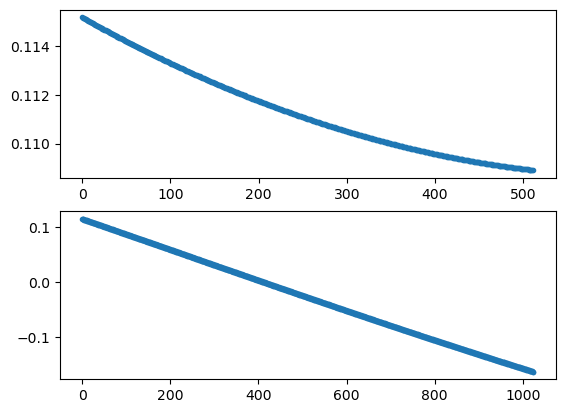

In [5]:
# %% Plot line plots
plt.figure()
plt.subplot(211)
plt.plot(gdtheta_plot[:,0], marker='.')
plt.subplot(212)
plt.plot(gdtheta_plot[0,:], marker='.')

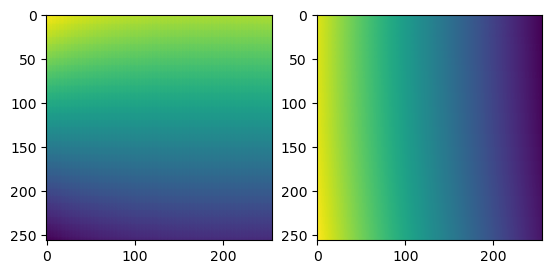

In [6]:
# %% Check against a grid in psi, theta

psiplot, gthetaplot = np.meshgrid(np.linspace(0.04, 0.16, 256), np.linspace(-0.1, 0.1, 256))
gdtheta_plot, grad_gdtheta_plot = geom.interp_gdtheta_grid(psiplot, gthetaplot, nu=(0,1))

fig, axs = plt.subplots(1,2)
axs[0].imshow(grad_gdtheta_plot[0,:,:])
axs[1].imshow(grad_gdtheta_plot[1,:,:])

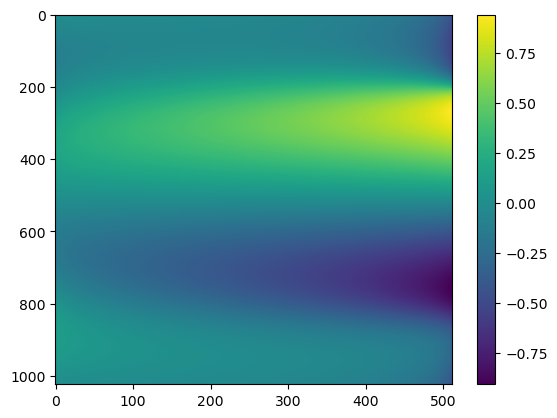

In [7]:
# %% Plot gdtheta_grid
plt.figure()
plt.imshow(geom.gdtheta_grid.T, aspect='auto')
plt.colorbar()

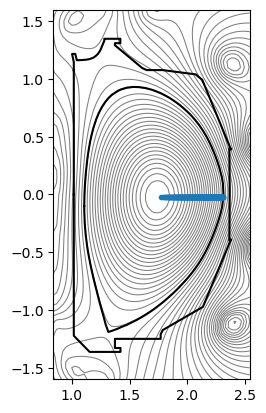

In [8]:
# %% Plot the equilibrium along with theta0
plt.figure()
ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax)

r0 = []
z0 = []

for ksurf in range(1, geom.nsurf):
    r = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],0]
    z = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],1]

    theta_surf = geom.theta_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1]]

    r0.append(scipy.interpolate.CubicSpline(periodify(theta_surf), periodify(r, period=0))(0))
    z0.append(scipy.interpolate.CubicSpline(periodify(theta_surf), periodify(z, period=0))(0))

plt.plot(r0, z0, marker='.')

In [9]:
# %% Compute r/a of the flux surface I'm looking at

ksurf = 200
r = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],0]
r2 = geom.rz_node[geom.breaks_surf[-2]:geom.breaks_surf[-1],0]
r_lcfs = np.max(r2 - eq.raxis)
r_surf = np.max(r-eq.raxis)

print(r_surf/r_lcfs)

0.8589280543115605


## Test Ballooning Interpolator

In [10]:
# %% Set up ballooning mode

fit_results = np.load('./outputs/fit_results.npz', allow_pickle=True)
params_g, params_gh = fit_results['params_g'], fit_results['params_gh']

# Set up the interpolator
mode = GaussHermiteFunction(params_g[:4], params_gh)

interp_balloon = [[(39, mode)]]

In [11]:
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation

In [12]:
# %% Compute phi
rplot, zplot = np.linspace(2.15, 2.26, 256), np.linspace(-0.2, 0.2, 1024)
rgrid, zgrid = np.meshgrid(rplot, zplot)
varphigrid = np.zeros(rgrid.shape)

rflat, zflat, varphiflat = rgrid.flatten(), zgrid.flatten(), varphigrid.flatten()

psi_ev, ff_ev = eq.compute_psi_and_ff(rflat, zflat)

phi = compute_balloon_interpolation(
    0.0, rflat, zflat, varphiflat, psi_ev, eq, geom, interp_balloon, gradient=False)

dphi = compute_balloon_interpolation(
    0.0, rflat, zflat, varphiflat, psi_ev, eq, geom, interp_balloon, gradient=True)

phigrid = phi.reshape(rgrid.shape)
dphirgrid = dphi[0,:].reshape(rgrid.shape)
dphivpgrid = dphi[1,:].reshape(rgrid.shape)
dphizgrid = dphi[2,:].reshape(rgrid.shape)

In [14]:
# %% Plot phi

%matplotlib qt

plt.figure()
plt.pcolormesh(rplot, zplot, phigrid, cmap='viridis')
plt.streamplot(rplot, zplot,
           -dphizgrid, dphirgrid, density=5, color='k', linewidth=0.3)
plt.axis('equal')

(2.1497843137254904,
 2.2602156862745097,
 -0.20019550342130987,
 0.2001955034213099)

In [28]:
emax = np.sqrt(np.max(dphizgrid**2+dphirgrid**2))
ksurf = 196
bsurf = geom.b_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1]]
bmin = np.min(np.linalg.norm(bsurf, axis=1))
print('eddy turnover time in microseconds:', 1e3 / (emax/bmin / (2*np.pi*20)))

eddy turnover time in microseconds: 673.1276744032245
